# 04.3 Working Geospatial Data: Raster Data 3

This notebook extends our hypsometric analysis by linking land-cover composition to elevation bands. We'll reuse helper utilities from the previous exercises to keep the workflow tidy and reproducible.

In [ ]:
import numpy as np
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import lulc_in_zrange # A set of utilities we developed! 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import pygeohydro as gh

elev_fname = '../data/ubrb_dem_30m.tif'
lulc_fname = '../data/upper_boise_landcover_30m.tif'
# elev_fname = '../data/hfork_ws_dem_30m.tif'
# lulc_fname = '../data/hfork_ws_lulc_30m.tif'

nlcd_cfile = './nlcd_classifications.csv'

delta_z = 100.0

## Import libraries and helper module

We load the scientific Python stack along with `lulc_in_zrange`, the helper module we extracted into its own `.py` file. Treating our helpers like a mini-library keeps the notebook focused on analysis steps rather than utility definitions.

## Load the DEM and gather basic stats

Open the elevation raster, compute high-level basin statistics, and print them so we know the terrain range we'll be binning later.

In [14]:
elev_data = rio.open(elev_fname)
elev_array = elev_data.read(1)

zmin = np.nanmin(elev_array)
zmax = np.nanmax(elev_array)
zmean = np.nanmax(elev_array)

zstats = f'''
Elevation Statistics:
Number of columns [east-west]: {elev_array.shape[1]} 
Number of rows [north-south]: {elev_array.shape[0]}
Minimum elevation: {zmin:.{2}f} m
Maximum elevation: {zmax:.{2}f} m
Mean elevation: {zmean:.{2}f} m
'''

print(zstats)


Elevation Statistics:
Number of columns [east-west]: 5433 
Number of rows [north-south]: 3239
Minimum elevation: 853.23 m
Maximum elevation: 3259.66 m
Mean elevation: 3259.66 m



## Load and clean the NLCD raster

Flip the data so north is up, convert to floats, and filter out nodata values before collecting the set of NLCD classes present in the basin.

In [15]:
lulc_data = rio.open(lulc_fname)
lulc_array = np.flipud(lulc_data.read(1))
lulc_array = lulc_array.astype('float')
lulc_array[lulc_array==0] = np.nan
lulc_bins = np.unique(lulc_array[~np.isnan(lulc_array)])

lulcstats = f'''
Land Use/Land Cover Present: {lulc_bins}
'''

print(lulcstats)


Land Use/Land Cover Present: [11. 12. 21. 22. 23. 24. 31. 41. 42. 43. 52. 71. 81. 82. 90. 95.]



## Define elevation bins

Round the extrema to the nearest `delta_z` increment so our hypsometry bins have clean boundaries.

In [16]:
z_bot = np.floor(zmin/delta_z)*delta_z
z_top = np.ceil(zmax/delta_z)*delta_z

## Generate bin edges

Build the array of elevation breakpoints that will anchor each band in the stacked plots.

In [17]:
z_intervals = np.arange(z_bot, z_top+delta_z, delta_z)

## Compute land-cover fractions per elevation band

Loop through each elevation slice, call our helper module to tally NLCD counts, and convert those counts to fractions for plotting.

In [ ]:
nz = z_intervals.size
nlulc = lulc_bins.size

LULCxZfracs = np.zeros((nz-1,nlulc))
Zfracs = np.zeros((nz-1))

for i in np.arange(nz-1):
    ranges = f'''
    Interval: {i}
    Bottom elevation: {z_intervals[i]:.{2}f}
    Top interval: {z_intervals[i+1]:.{2}f}
    '''
    print(ranges)

    # Use our helper module (stored in `lulc_in_zrange.py`) to tally NLCD counts within this elevation band
    lulc_dz = lulc_in_zrange.lulc_in_zrange(lulc_array, lulc_bins, elev_array, z_intervals[i], z_intervals[i+1])

    lulc_fracs_dz = lulc_dz/lulc_dz.sum()

    Zfracs[i] = lulc_dz.sum()/elev_array.size
    LULCxZfracs[i,:] = lulc_fracs_dz



    Interval: 0
    Bottom elevation: 800.00
    Top interval: 900.00
    

    Interval: 1
    Bottom elevation: 900.00
    Top interval: 1000.00
    

    Interval: 2
    Bottom elevation: 1000.00
    Top interval: 1100.00
    

    Interval: 3
    Bottom elevation: 1100.00
    Top interval: 1200.00
    

    Interval: 4
    Bottom elevation: 1200.00
    Top interval: 1300.00
    

    Interval: 5
    Bottom elevation: 1300.00
    Top interval: 1400.00
    

    Interval: 6
    Bottom elevation: 1400.00
    Top interval: 1500.00
    

    Interval: 7
    Bottom elevation: 1500.00
    Top interval: 1600.00
    

    Interval: 8
    Bottom elevation: 1600.00
    Top interval: 1700.00
    

    Interval: 9
    Bottom elevation: 1700.00
    Top interval: 1800.00
    

    Interval: 10
    Bottom elevation: 1800.00
    Top interval: 1900.00
    

    Interval: 11
    Bottom elevation: 1900.00
    Top interval: 2000.00
    

    Interval: 12
    Bottom elevation: 2000.00
    Top interval:

## Plot stacked land-cover profile

Use the NLCD color legend to draw a stacked horizontal bar chart showing how land-cover proportions change with elevation.

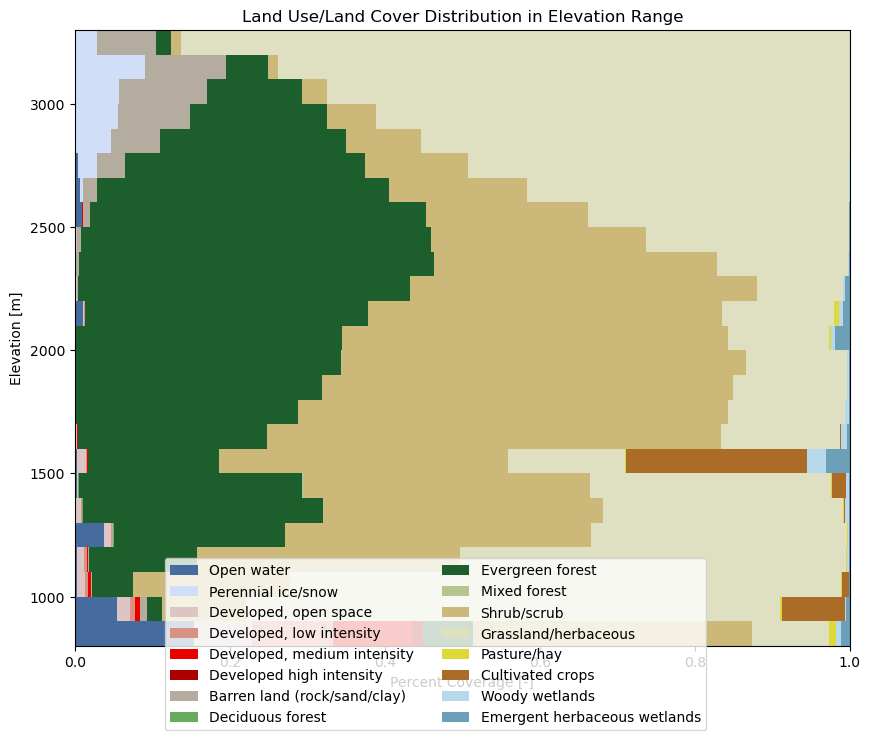

In [19]:
# Create NLCD colormap 
nlcd_df = pd.read_csv(nlcd_cfile)

# Use pygeohydro to retrieve the standard NLCD colormap
cmap_nlcd, norm_nlcd, levels = gh.plot.cover_legends()

fig, ax = plt.subplots(figsize=(10,8))

left = np.zeros((nz-1))

z_plot = z_intervals[:-1]+delta_z/2

for i in np.arange(lulc_bins.size):
    lulc_fracs = LULCxZfracs[:,i]
    ax.barh(z_plot, lulc_fracs, left=left, 
            height=delta_z, color=cmap_nlcd.colors[i+1], 
            label=nlcd_df.label_short.values[i])
    left += LULCxZfracs[:,i]

ax.set_ylim([z_intervals[0],z_intervals[-1]])
ax.set_xlim([0,1])
ax.set_title('Land Use/Land Cover Distribution in Elevation Range')
ax.set_xlabel('Percent Coverage [-]')
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_ylabel('Elevation [m]')
fig.legend(fontsize=10, ncol=2, loc='outside lower center')
plt.show()

## Pair land-cover profile with elevation histogram

Combine the stacked profile with the elevation-area histogram to see both land-cover composition and elevation distribution on the same figure.

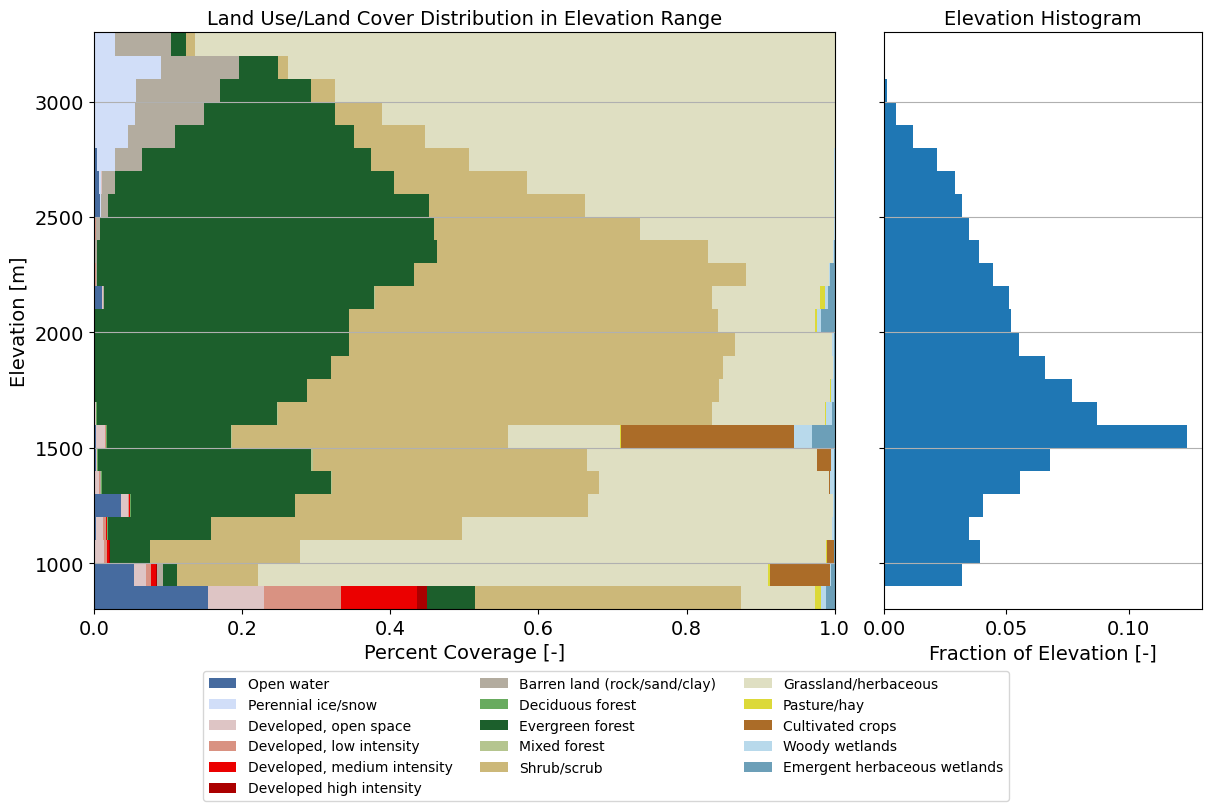

In [20]:
fig, axs = plt.subplot_mosaic([['left','right']], layout='constrained', figsize=(12,8), width_ratios=[0.7, 0.3])

left = np.zeros((nz-1))

z_plot = z_intervals[:-1]+delta_z/2

for i in np.arange(lulc_bins.size):
    lulc_fracs = LULCxZfracs[:,i]
    axs['left'].barh(z_plot, lulc_fracs, left=left, 
            height=delta_z, color=cmap_nlcd.colors[i+1], 
            label=nlcd_df.label_short.values[i])
    left += LULCxZfracs[:,i]

axs['left'].set_ylim([z_intervals[0],z_intervals[-1]])
axs['left'].set_xlim([0,1])
axs['left'].set_title('Land Use/Land Cover Distribution in Elevation Range',fontsize=14)
axs['left'].set_xlabel('Percent Coverage [-]',fontsize=14)
axs['left'].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs['left'].set_ylabel('Elevation [m]',fontsize=14)
axs['left'].grid('on', which='major', axis='y')
axs['left'].tick_params(axis='both', which='major', labelsize=14)

axs['right'].barh(z_plot,Zfracs, height=delta_z)
axs['right'].set_ylim([z_intervals[0],z_intervals[-1]])
axs['right'].set_title('Elevation Histogram',fontsize=14)
axs['right'].set_xlabel('Fraction of Elevation [-]',fontsize=14)
axs['right'].set_ylabel('') 
axs['right'].grid('on', which='major', axis='y')
axs['right'].set_yticklabels([])
axs['right'].tick_params(axis='both', which='major', labelsize=14)

fig.legend(fontsize=10, ncol=3, loc='outside lower center')

plt.savefig('../generated_images/hfork_ws_lulc_vs_elev.png',dpi=300)
plt.show()

## Wrap-up

Thanks to the standalone helper module, this notebook stays focused on the comparative plots. Try changing `delta_z`, swapping watersheds, or extending the helper module with additional summary metrics.